This notebook contains my implementation of the multivariate gaussian distribution, including both the probability density function (pdf) and the cumulative distribution function implemented using monte carlo integration with random sampling.

You can check out my chapter notes for more info on the MVN in general.

With regards to my implementation of the cdf:

**Monte Carlo Integration** is a technique for approximating integral evaluations using random sampling.

In my case, this is useful because the cdf of a MVN does not have a closed - form solution, so P(Y <= y) must be approximated.

If we take the standard definition of an integral in high dimensions:

$$
\int_{R}{f(y)}
$$

We can reframe the problem to be the average of $f$ over region $R$ multiplied by the volume of $R$, which is $V$.

$$
V \cdot \text{avg}_R(f)
$$

Now, all we really need is to estimate the average value of f over the region R. We can do this by randomly sampling N times from R: $x_1, ...x_N$

$$
V \frac{1}{N} \sum f(x_i)
$$

As $N \rightarrow \infin$, this estimate approaches the true average.

As far as how we choose to sample, I personally chose to sample from a uniform distribution where each dimension {j} of the MVN is distributed as follows:

$$
x_{i,j} \sim U(\mu_j - \lambda \sigma_j, y_j)
$$

This essentially just means that thh upper bound is the point we're evaluating, and the lower bound is some multiple $\lambda$ of the standard deviation below the mean of that dimension for the distribution.




In [274]:
import numpy as np
from tqdm import tqdm

In [126]:
class MVN:
    def __init__(self, mean: np.array, covariance: np.array):   
        """Initialize a multivariate normal distribution

        Args:
            mean (np.array): a vector of mean values
            covariance (np.array): a covariance matrix 

        Raises:
            ValueError: if mean is not a vector
            ValueError: if covariance is not a 2-D, square, symmetric matrix 
            ValueError: if the dimensionality of mean and covariance do not match
        """
        if mean.ndim != 1:
            raise ValueError('mean must be a 1-D vector')
        
        if (covariance.ndim != 2) or (covariance.shape[0] != covariance.shape[1]) or (np.any(covariance.T != covariance)):
            raise ValueError('covariance must be a 2-D, square, symmetric matrix')
        
        if mean.shape[0] != covariance.shape[0]:
            raise ValueError('mean and covariance must have the same dimensionality')
        
        self.mean = mean
        self.covariance = covariance
        self.d = self.mean.shape[0] # mean

    def evaluate_pdf(self, y: np.array) -> float:
        """Evaluate the probability density function (pdf) for a new sample

        Args:
            y (np.array): a new sample or samples

        Raises:
            ValueError: if y is not a 1-D vector or if its dimensions to not match the distribution

        Returns:
            float or np.array: the probability density of the MVN at point y. Note this does not represent the probability itself
        """
        if not np.isin(y.ndim, [1, 2]) and y.shape[y.ndim - 1] == self.d:
            raise ValueError('y must be either a vector with shape (d,) or a matrix with shape (n, d), where n is the number of samples and d is the dimension')

        normalization_constant = 1 / (np.power((2 * np.pi), self.d / 2) * np.power(np.linalg.det(self.covariance), .5)) 

        if y.ndim == 1:
            # (1, m) @ (m x m) @ (m x 1) --> scalar
            exponential_term = np.exp(-.5 * (np.expand_dims(y - self.mean, axis=0) @ np.linalg.inv(self.covariance) @ (y - self.mean)))
        else:
            y_minus_mean = y - np.expand_dims(self.mean, axis=0)
            # (n x D) @ (D x D) @ (D x n) ----weird einsum----> (n x 1)
            exponential_term = np.exp(-.5 * np.einsum('ij,ji->i', y_minus_mean @ np.linalg.inv(self.covariance),  y_minus_mean.T)) 

        return normalization_constant * exponential_term
    
    def evaluate_cdf(self, y: np.array, n_samples: int = 100_000, n_stds: int = 5, rand_seed: int = None) -> float:
        """Evaluate the cumulative distribution function for a new sample using monte carlo integration w/ uniform sampling: P(Y <= y)

        Args:
            y (np.array): new sample
            n_samples (int, optional): number of samples for monte carlo integration. Defaults to 10_000.
            n_stds (int, optional): number of standard deviations below the mean to use as the lower integral term. Defaults to 5.
            rand_seed (int, optional): random seed. Defaults to None.

        Returns:
            float: estimated cumulative probability: P(Y <= y)
        """
        low = self.mean - (np.diag(self.covariance) * n_stds)
        generator = np.random.default_rng(rand_seed)

        samples = generator.uniform(low=low, high=y, size=(n_samples, self.d))

        probability_densities = self.evaluate_pdf(samples)

        return np.prod(y - low) * probability_densities.mean()

In [297]:
mean = np.array([1.3, -2.1])
covariance = np.array([[3.1, 1.2],[1.2, 1.5]])

mvn = MVN(mean, covariance)

# Plot the MVN

In [298]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

In [299]:
# construct dummy samples
n_dummy_samples = 100

dummy = np.linspace(start = -5, stop = 5, num = n_dummy_samples)

X, Y = np.meshgrid(dummy, dummy)

dummy_samples = np.array([[x, y] for x in dummy for y in dummy])

dummy_samples.shape

(10000, 2)

In [300]:
# evaluate both the pdf and cdf at all dummy samples
probs = mvn.evaluate_pdf(dummy_samples)
probs_cdf = np.array([mvn.evaluate_cdf(sample) for sample in tqdm(dummy_samples)])

100%|██████████| 10000/10000 [00:43<00:00, 228.18it/s]


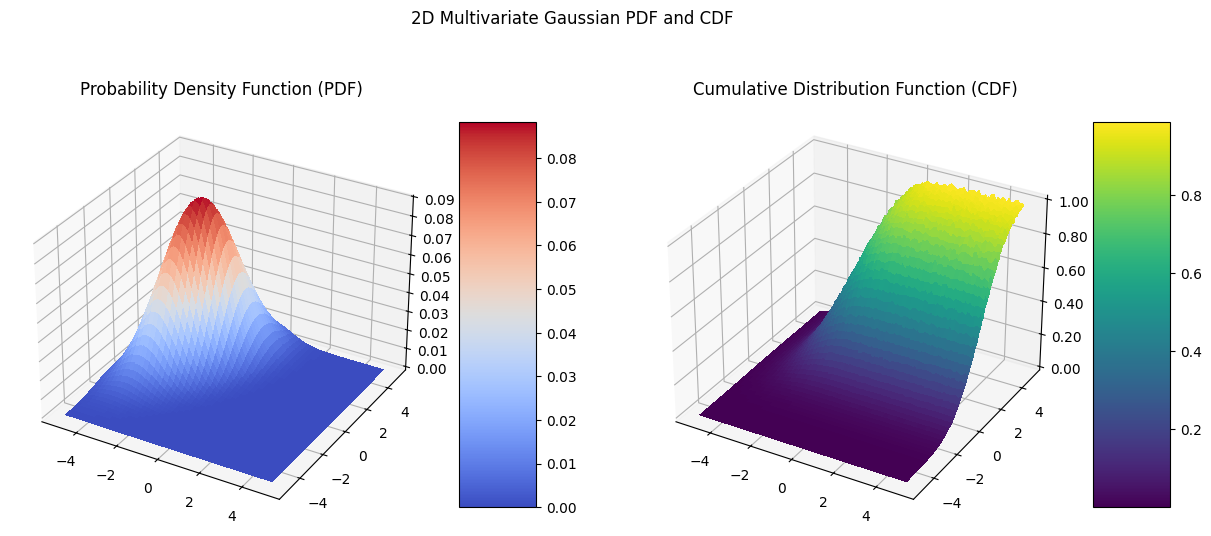

In [301]:
# plot the pdf and cdf over the dummy sample grid
fig, ax = plt.subplots(ncols = 2, subplot_kw={"projection": "3d"}, figsize=(15,10))

ax[0].set_title('Probability Density Function (PDF)')
surf_pdf= ax[0].plot_surface(X, Y, probs.reshape(100, 100), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax[0].zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf_pdf, shrink=0.5, aspect=5)

ax[1].set_title('Cumulative Distribution Function (CDF)')
surf_cdf = ax[1].plot_surface(X, Y, probs_cdf.reshape(100, 100), cmap=cm.viridis,
                       linewidth=0, antialiased=False)

ax[1].zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf_cdf, shrink=0.5, aspect=5)

fig.suptitle('2D Multivariate Gaussian PDF and CDF', y=.8)

plt.show()